<a href="https://colab.research.google.com/github/Saurabh-data-science/Python-for-Data-Analysis/blob/main/Saurabh_Chauhan_CPDA_Batch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# A. Imports and display settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.1)
pd.set_option("display.max_columns", 50)

# B. Load data
users = pd.read_csv("/content/users_data.csv")
cards = pd.read_csv("cards_data.csv")
trans = pd.read_csv("transactions_data.csv")

users.head(), cards.head(), trans.head()


(     id  current_age  retirement_age  birth_year  birth_month  gender  \
 0   825           53              66        1966           11  Female   
 1  1746           53              68        1966           12  Female   
 2  1718           81              67        1938           11  Female   
 3   708           63              63        1957            1  Female   
 4  1164           43              70        1976            9    Male   
 
                     address  latitude  longitude per_capita_income  \
 0             462 Rose Lane     34.15    -117.76            $29278   
 1    3606 Federal Boulevard     40.76     -73.74            $37891   
 2           766 Third Drive     34.02    -117.89            $22681   
 3          3 Madison Street     40.71     -73.99           $163145   
 4  9620 Valley Stream Drive     37.76    -122.44            $53797   
 
   yearly_income total_debt  credit_score  num_credit_cards  
 0        $59696    $127613           787                 5  
 1

## Task A

In [18]:
# Check dtypes
users.dtypes, cards.dtypes, trans.dtypes


(id                     int64
 current_age            int64
 retirement_age         int64
 birth_year             int64
 birth_month            int64
 gender                object
 address               object
 latitude             float64
 longitude            float64
 per_capita_income     object
 yearly_income         object
 total_debt            object
 credit_score           int64
 num_credit_cards       int64
 dtype: object,
 id                        int64
 client_id                 int64
 card_brand               object
 card_type                object
 card_number               int64
 expires                  object
 cvv                       int64
 has_chip                 object
 num_cards_issued          int64
 credit_limit             object
 acct_open_date           object
 year_pin_last_changed     int64
 card_on_dark_web         object
 dtype: object,
 id                  int64
 date               object
 client_id           int64
 card_id             int64
 amount    

In [20]:
# Convert continuous columns in users
num_cols_users = [
    "current_age", "retirement_age", "birth_year", "birth_month",
    "latitude", "longitude", "per_capita_income", "yearly_income",
    "total_debt", "credit_score", "num_credit_cards"
]
for col in num_cols_users:
    users[col] = pd.to_numeric(users[col], errors="coerce")

# Convert continuous columns in cards
num_cols_cards = ["num_cards_issued", "credit_limit", "year_pin_last_changed"]
for col in num_cols_cards:
    cards[col] = pd.to_numeric(cards[col], errors="coerce")

# Clean amount (e.g. "$46.26" -> 46.26)
trans["amount"] = (
    trans["amount"]
    .astype(str)
    .str.replace(r"[^0-9.\-]", "", regex=True)
    .replace("", np.nan)
    .astype(float)
)

errors="coerce" is used and that “amount” is now numeric.

Duplicates

In [21]:
print("Users duplicates:", users.duplicated().sum())
print("Cards duplicates:", cards.duplicated().sum())
print("Trans duplicates:", trans.duplicated().sum())

users = users.drop_duplicates().reset_index(drop=True)
cards = cards.drop_duplicates().reset_index(drop=True)
trans = trans.drop_duplicates().reset_index(drop=True)


Users duplicates: 0
Cards duplicates: 0
Trans duplicates: 0


Missing values + simple visualization


In [22]:
def missing_summary(df, name):
    miss = df.isna().sum()
    miss = miss[miss > 0]
    print(f"\nMissing values in {name}:")
    print(miss)

missing_summary(users, "users")
missing_summary(cards, "cards")
missing_summary(trans, "transactions")



Missing values in users:
per_capita_income    25
yearly_income        25
total_debt           25
dtype: int64

Missing values in cards:
credit_limit    75
dtype: int64

Missing values in transactions:
merchant_state     8008
zip                8358
errors            49145
dtype: int64


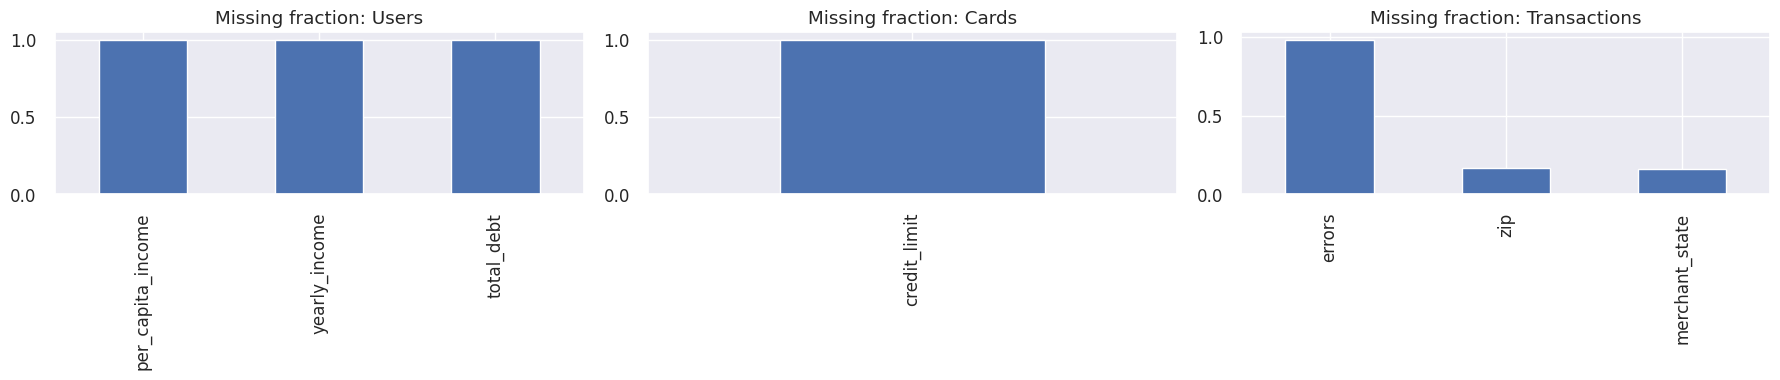

In [24]:
# Simple barplot of missingness for each table
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
for ax, df, title in zip(
    axes, [users, cards, trans], ["Users", "Cards", "Transactions"]
):
    miss = df.isna().mean()
    miss = miss[miss > 0]
    miss.sort_values(ascending=False).plot.bar(ax=ax)
    ax.set_title(f"Missing fraction: {title}")
plt.tight_layout()
plt.show()


Normalize use_chip to swipe / chip / online


In [26]:
def normalize_use_chip(x):
    if pd.isna(x):
        return np.nan
    x = str(x).strip().lower()
    # map common patterns – adjust based on your data
    if x in ["yes", "y", "chip", "chip_read", "icc"]:
        return "chip"
    if x in ["no", "swipe", "magstripe"]:
        return "swipe"
    if x in ["online", "ecom", "card_not_present"]:
        return "online"
    return "online"  # fallback assumption

trans["use_chip"] = trans["use_chip"].apply(normalize_use_chip)
trans["use_chip"].value_counts(dropna=False)


,count
use_chip,
online,50000


Clean city names

In [27]:
trans["merchant_city"] = (
    trans["merchant_city"]
    .astype(str)
    .str.strip()
    .str.lower()
    .str.title()
)
trans["merchant_city"].head()


,merchant_city
0,Online
1,Phoenix
2,Spring Valley
3,Phoenix
4,Boyne City


Normalize state codes to two capital letters


In [28]:
trans["merchant_state"] = (
    trans["merchant_state"]
    .astype(str)
    .str.strip()
    .str.upper()
    .str[:2]
)
trans["merchant_state"].unique()[:10]


array(['NA', 'AZ', 'CA', 'MI', 'KY', 'LA', 'OK', 'PA', 'NY', 'WI'],
      dtype=object)

ZIP as 5‑digit string with leading zeros

In [29]:
trans["zip"] = (
    trans["zip"]
    .astype(str)
    .str.extract(r"(\d+)", expand=False)   # keep only digits
    .fillna("00000")
    .str.zfill(5)
)
trans["zip"].head()


,zip
0,00000
1,85015
2,91977
3,85015
4,49712


## Task B

Customer card profile

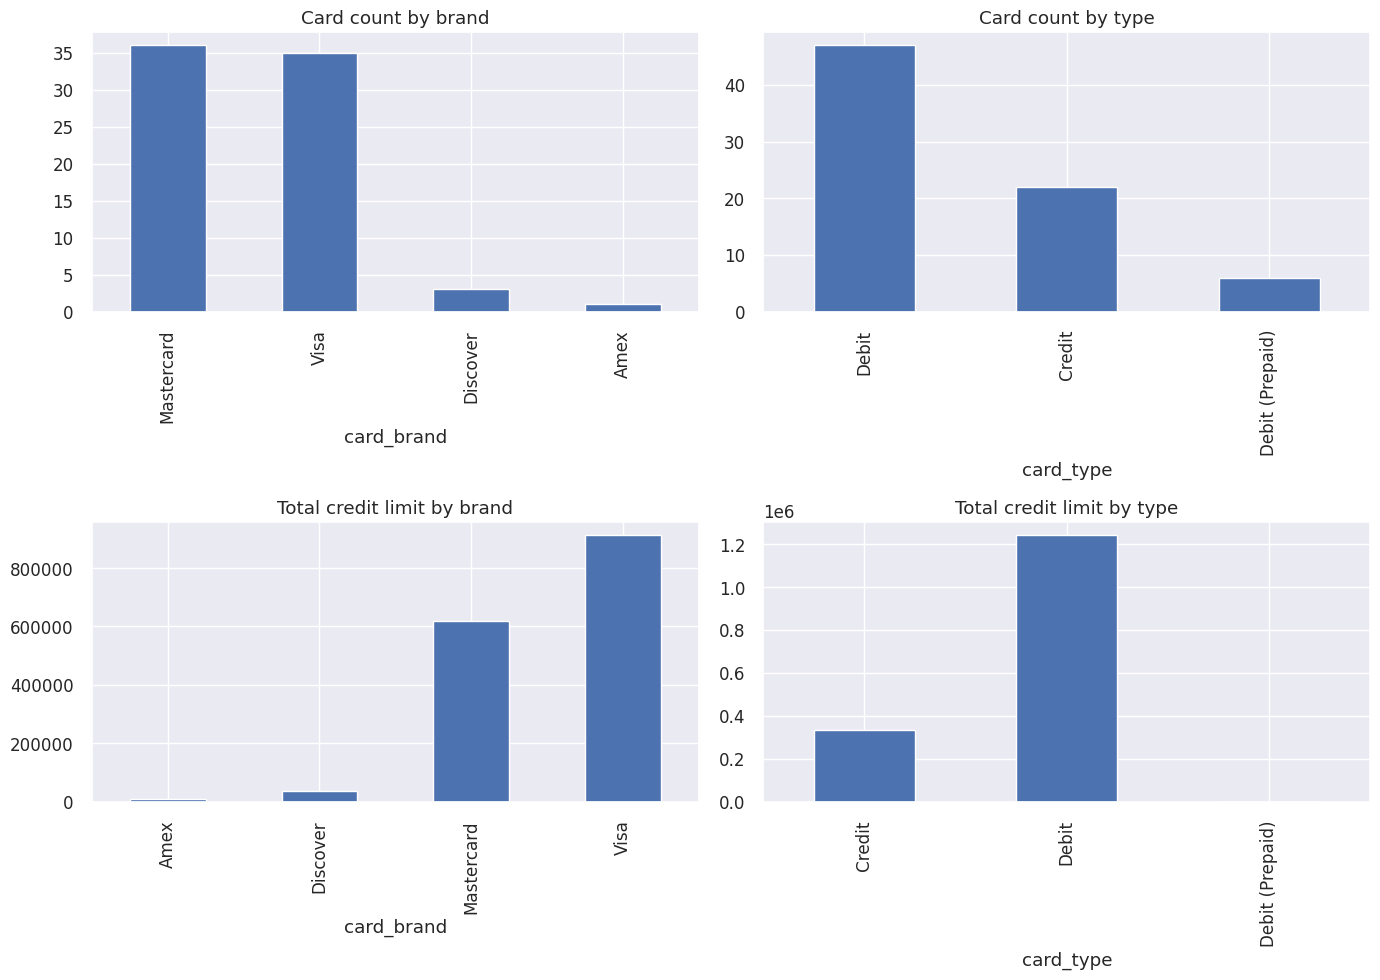

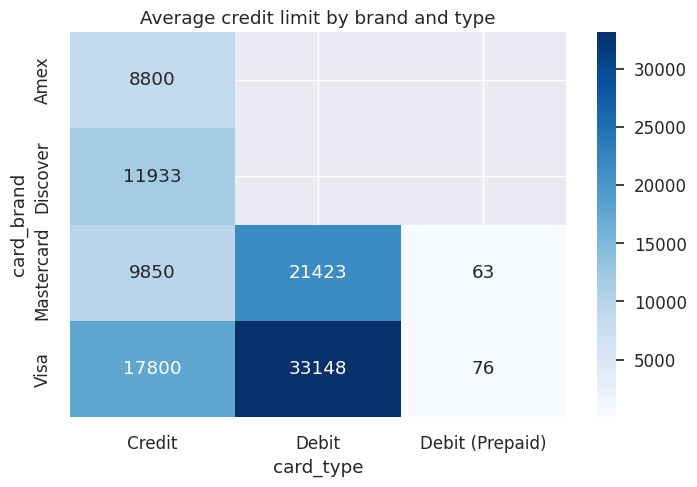

In [37]:
# Re-load cards specifically to ensure credit_limit has original string format for cleaning
# This step is necessary because 'credit_limit' was turned into NaNs in an earlier cell
# without proper string cleaning, making the first cleaning attempt in this cell ineffective.
temp_cards = pd.read_csv("cards_data.csv")
cards["credit_limit"] = temp_cards["credit_limit"]

# Now, clean credit_limit column similar to 'amount' in transactions before merging
cards["credit_limit"] = (
    cards["credit_limit"]
    .astype(str)
    .str.replace(r"[^0-9.\-]", "", regex=True)
    .replace("", np.nan)
    .astype(float)
)

# Merge users & cards
user_cards = cards.merge(users, left_on="client_id", right_on="id", how="left",
                         suffixes=("_card", "_user"))

# Explore distribution of brands and types
brand_counts = user_cards["card_brand"].value_counts()
type_counts = user_cards["card_type"].value_counts()
credit_by_brand = user_cards.groupby("card_brand")["credit_limit"].sum()
credit_by_type = user_cards.groupby("card_type")["credit_limit"].sum()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

brand_counts.plot(kind="bar", ax=axes[0,0], title="Card count by brand")
type_counts.plot(kind="bar", ax=axes[0,1], title="Card count by type")
credit_by_brand.plot(kind="bar", ax=axes[1,0], title="Total credit limit by brand")
credit_by_type.plot(kind="bar", ax=axes[1,1], title="Total credit limit by type")

for ax in axes.ravel():
    ax.set_ylabel("")
plt.tight_layout()
plt.show()

# Heatmap: avg credit_limit by brand & type
pivot_ct = user_cards.pivot_table(
    index="card_brand", columns="card_type", values="credit_limit", aggfunc="mean"
)
plt.figure(figsize=(8,5))
sns.heatmap(pivot_ct, annot=True, fmt=".0f", cmap="Blues")
plt.title("Average credit limit by brand and type")
plt.show()

Explore transactions

In [36]:
# Time frame
trans["date"] = pd.to_datetime(trans["date"])
trans["date"].agg(["min", "max"])


,date
min,2010-01-01 04:45:00
max,2012-10-29 12:55:00


In [35]:
# Which client spent the most
client_spend = trans.groupby("client_id")["amount"].sum().sort_values(ascending=False)
client_spend.head()

# Highest and lowest transaction amounts
trans["amount"].max(), trans["amount"].min()


(6820.2, -500.0)

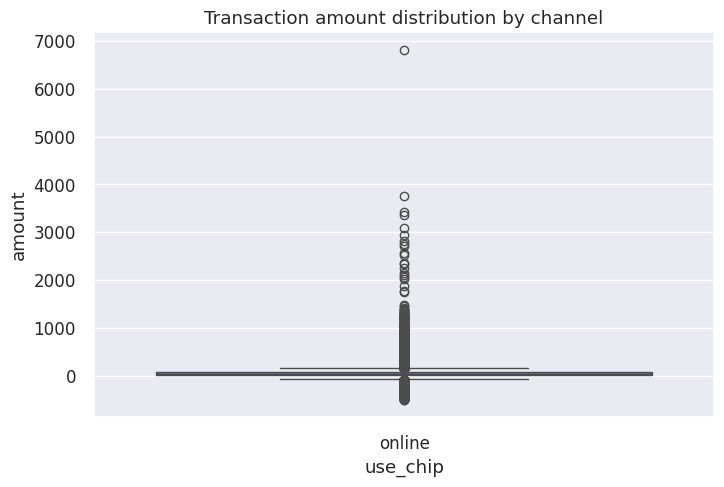

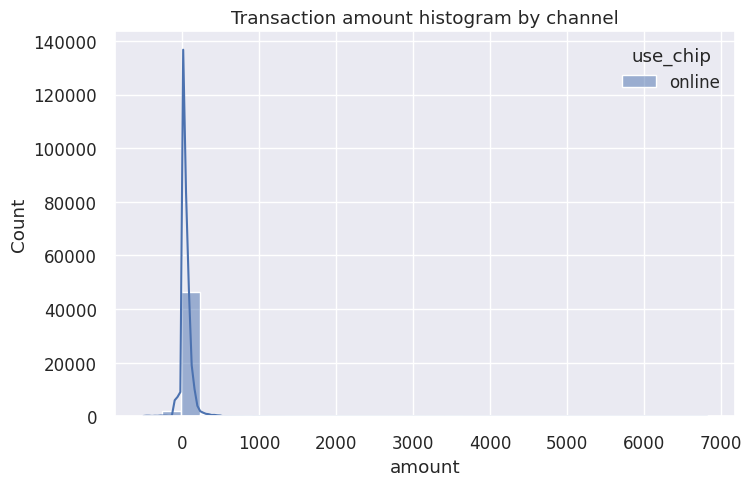

In [34]:
# Amount distribution by use_chip
plt.figure(figsize=(8,5))
sns.boxplot(data=trans, x="use_chip", y="amount")
plt.title("Transaction amount distribution by channel")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(data=trans, x="amount", hue="use_chip", bins=30, kde=True)
plt.title("Transaction amount histogram by channel")
plt.show()


Customer spend profile vs credit health

In [38]:
# Basic transaction aggregates per client
trans["month"] = trans["date"].dt.to_period("M")

client_agg = (
    trans.groupby("client_id")
    .agg(
        total_spend=("amount", "sum"),
        avg_ticket=("amount", "mean"),
        txn_count=("id", "count"),
        active_months=("month", "nunique"),
    )
    .reset_index()
)
client_agg["monthly_freq"] = client_agg["txn_count"] / client_agg["active_months"]

client_agg.head()


,client_id,total_spend,avg_ticket,txn_count,active_months,monthly_freq
0,68,202013.82,57.098310,3538,34,104.058824
1,153,70806.08,55.447204,1277,34,37.558824
2,511,285794.61,43.646092,6548,34,192.588235
3,708,326179.31,132.917404,2454,34,72.176471
4,825,259484.68,81.088962,3200,34,94.117647


In [40]:
# Credit health dataframe (users)
credit_df = users[[
    "id", "credit_score", "yearly_income", "total_debt", "num_credit_cards"
]].rename(columns={"id": "client_id"})

# Merge spend + credit
client_profile = client_agg.merge(credit_df, on="client_id", how="left")
client_profile.head()

,client_id,total_spend,avg_ticket,txn_count,active_months,monthly_freq,credit_score,yearly_income,total_debt,num_credit_cards
0,68,202013.82,57.098310,3538,34,104.058824,704,NaN,NaN,3
1,153,70806.08,55.447204,1277,34,37.558824,660,NaN,NaN,4
2,511,285794.61,43.646092,6548,34,192.588235,661,NaN,NaN,5
3,708,326179.31,132.917404,2454,34,72.176471,722,NaN,NaN,4
4,825,259484.68,81.088962,3200,34,94.117647,787,NaN,NaN,5


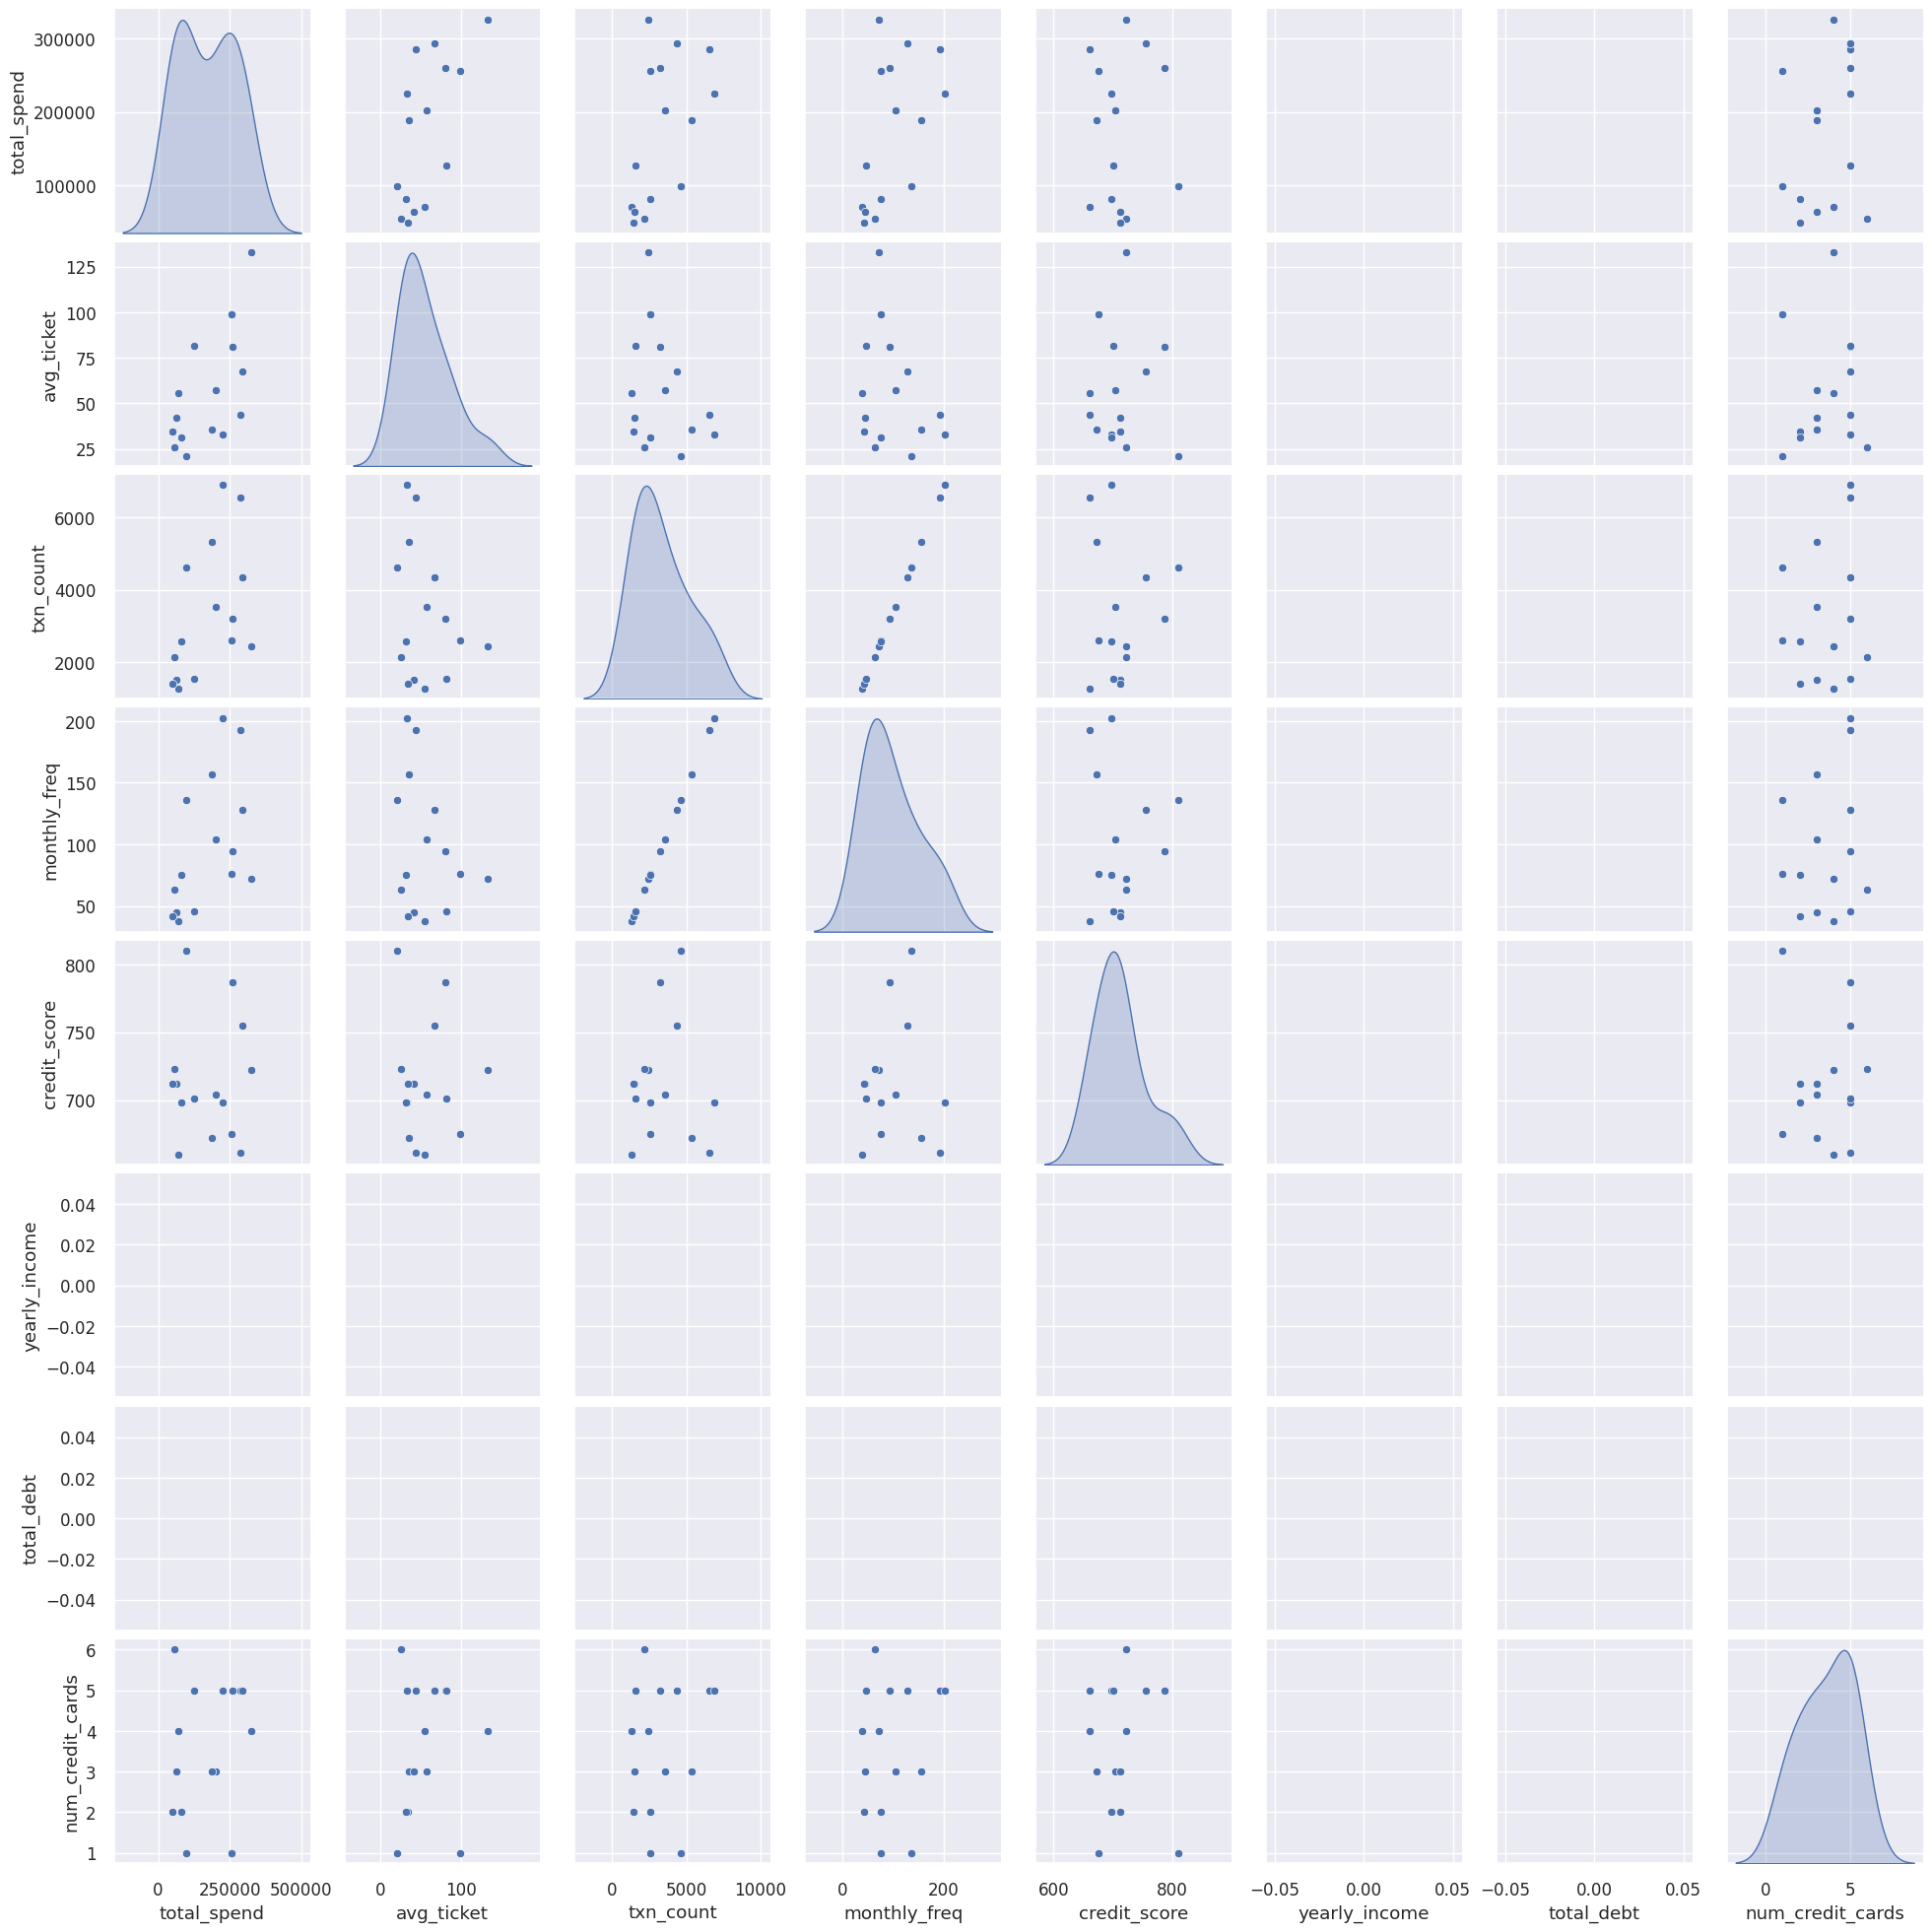

/tmp/ipython-input-859922806.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
/tmp/ipython-input-859922806.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")


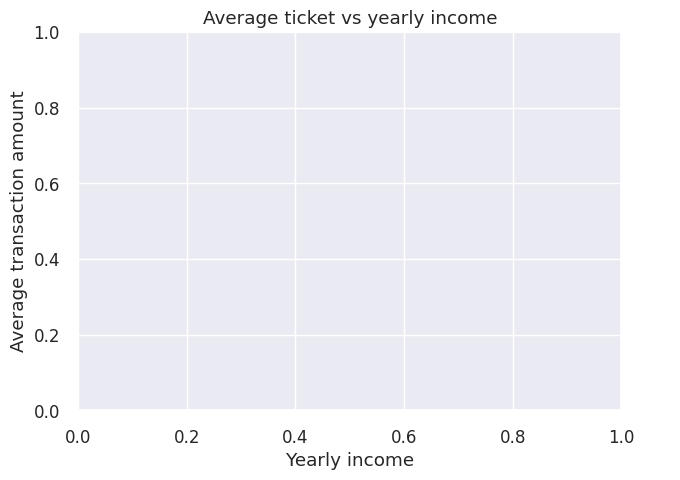

In [41]:
# Pairwise relationships
sns.pairplot(
    client_profile,
    vars=["total_spend", "avg_ticket", "txn_count", "monthly_freq",
          "credit_score", "yearly_income", "total_debt", "num_credit_cards"],
    diag_kind="kde"
)
plt.show()

# Scatter: average amount vs yearly_income
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=client_profile,
    x="yearly_income", y="avg_ticket", size="credit_score", hue="total_debt", palette="viridis"
)
plt.title("Average ticket vs yearly income")
plt.xlabel("Yearly income")
plt.ylabel("Average transaction amount")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

higher income correlates with higher average ticket, high‑debt + high‑spend + low‑score customers need monitoring.

Age portfolio

In [42]:
# Age bands
bins = [0, 25, 35, 45, 60, 100]
labels = ["<25", "25-35", "35-45", "45-60", "60+"]
users["age_band"] = pd.cut(users["current_age"], bins=bins, labels=labels, right=False)

age_share = users["age_band"].value_counts(normalize=True).sort_index()
age_share


,proportion
age_band,
<25,0.12
25-35,0.24
35-45,0.16
45-60,0.20
60+,0.28


In [44]:
# Avg credit limit by band
age_credit = (
    users[["id", "age_band"]]
    .merge(cards[["client_id", "credit_limit"]], left_on="id", right_on="client_id", how="left")
    .groupby("age_band")["credit_limit"].mean()
)
age_credit


/tmp/ipython-input-3787128202.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("age_band")["credit_limit"].mean()


,credit_limit
age_band,
<25,35299.333333
25-35,13548.000000
35-45,13798.615385
45-60,15102.111111
60+,28256.444444


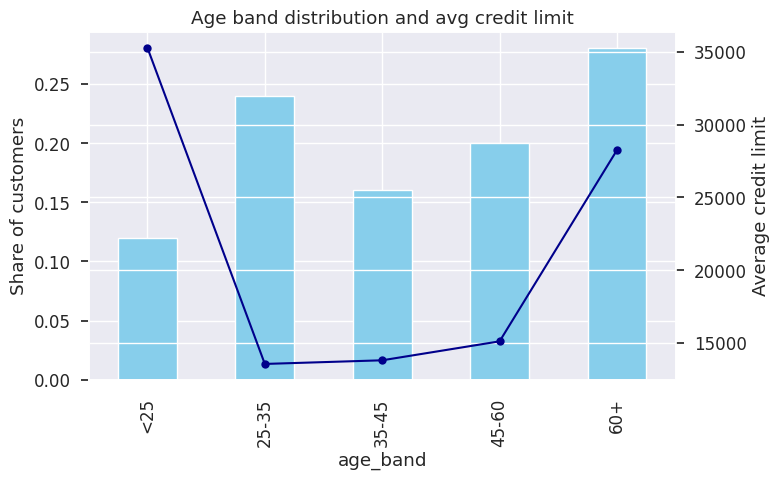

In [45]:
fig, ax1 = plt.subplots(figsize=(8,5))

age_share.plot(kind="bar", ax=ax1, color="skyblue", label="Customer share")
ax1.set_ylabel("Share of customers")
ax1.set_title("Age band distribution and avg credit limit")

ax2 = ax1.twinx()
age_credit.plot(kind="line", marker="o", color="darkblue", ax=ax2, label="Avg credit limit")
ax2.set_ylabel("Average credit limit")

fig.tight_layout()
plt.show()


Chip usage, income, credit score vs age:



/tmp/ipython-input-2113384179.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_trans.groupby(["age_band", "use_chip"])["id_x"]  # id_x is transaction id from merge
/tmp/ipython-input-2113384179.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(level=0)


<Figure size 800x500 with 0 Axes>

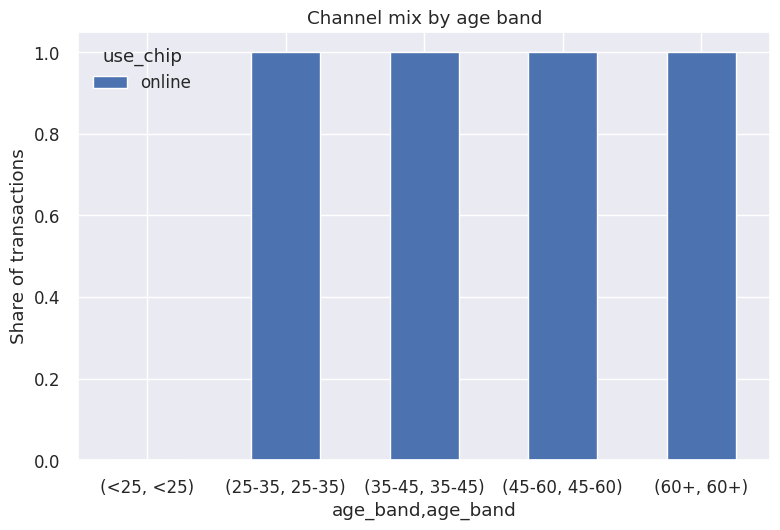

/tmp/ipython-input-2113384179.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  users.groupby("age_band")[["yearly_income", "credit_score"]]


,yearly_income,credit_score
age_band,,
<25,NaN,719.666667
25-35,NaN,743.166667
35-45,NaN,693.500000
45-60,NaN,704.000000
60+,NaN,700.857143


In [46]:
# Join age with spend and use_chip
age_trans = trans.merge(users[["id", "current_age", "age_band"]], left_on="client_id",
                        right_on="id", how="left")

# Chip usage rate by age band
chip_usage = (
    age_trans.groupby(["age_band", "use_chip"])["id_x"]  # id_x is transaction id from merge
    .count()
    .groupby(level=0)
    .apply(lambda x: x / x.sum())
    .unstack()
)
plt.figure(figsize=(8,5))
chip_usage.plot(kind="bar", stacked=True)
plt.title("Channel mix by age band")
plt.ylabel("Share of transactions")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Income and credit score by age band
age_metrics = (
    users.groupby("age_band")[["yearly_income", "credit_score"]]
    .mean()
)
age_metrics


 Gender analysis

In [47]:
# Merge gender into transactions
trans_gender = trans.merge(users[["id", "gender"]], left_on="client_id",
                           right_on="id", how="left")

# Avg txn amount by gender
avg_amt_gender = trans_gender.groupby("gender")["amount"].mean()
avg_amt_gender


,amount
gender,
Female,51.678074
Male,51.573033


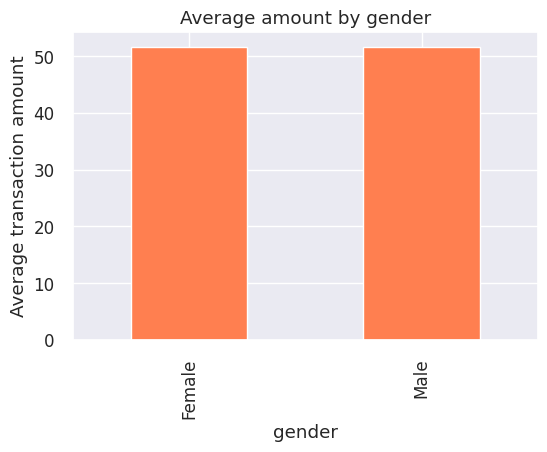

In [48]:
plt.figure(figsize=(6,4))
avg_amt_gender.plot(kind="bar", color="coral")
plt.ylabel("Average transaction amount")
plt.title("Average amount by gender")
plt.show()


Time‑of‑day / day‑of‑week:



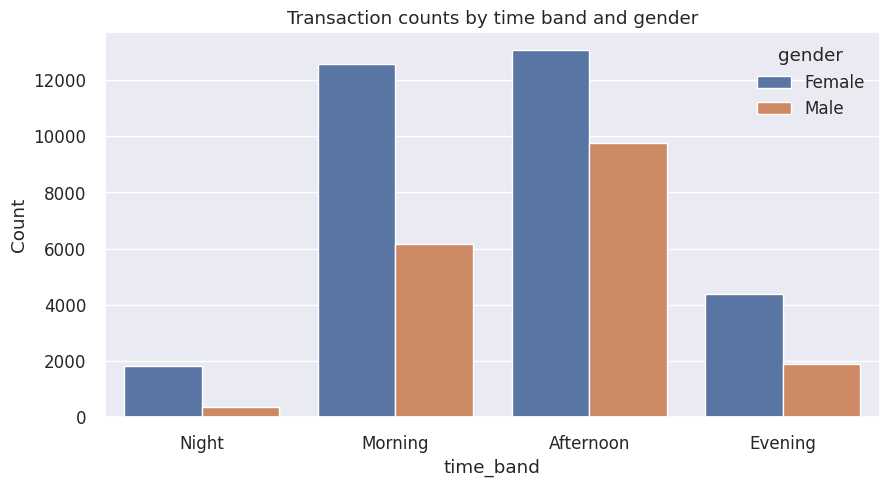

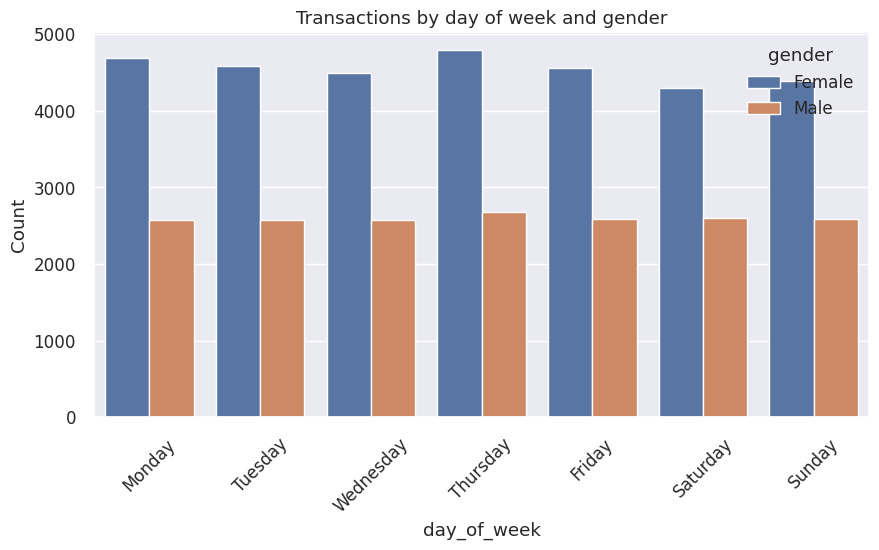

In [49]:
trans_gender["hour"] = trans_gender["date"].dt.hour
trans_gender["day_of_week"] = trans_gender["date"].dt.day_name()

# Boxplot by gender & hour bucket
trans_gender["time_band"] = pd.cut(
    trans_gender["hour"],
    bins=[0, 6, 12, 18, 24],
    labels=["Night", "Morning", "Afternoon", "Evening"],
    right=False
)

plt.figure(figsize=(10,5))
sns.countplot(data=trans_gender, x="time_band", hue="gender")
plt.title("Transaction counts by time band and gender")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10,5))
sns.countplot(data=trans_gender, x="day_of_week", hue="gender",
              order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.xticks(rotation=45)
plt.title("Transactions by day of week and gender")
plt.ylabel("Count")
plt.show()


If one gender spends more on weekends evenings, propose weekend entertainment / dining offers.

If online usage is high for young females, propose “online‑only cashback” or push‑notification campaigns.